#**Neural Style Transfer using Tensorflow**

In [ ]:
# For downloading test images
!git clone https://github.com/Rudrransh17/Neural-Style-Transfer.git

fatal: destination path 'Neural-Style-Transfer' already exists and is not an empty directory.


In [ ]:
# Import required dependencies
import tensorflow as tf
from tensorflow.keras.applications import VGG19
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage as ndimage
from scipy.signal import convolve2d

In [ ]:
# Download the model without top dense layers
vgg = VGG19(weights='imagenet', include_top=False)
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
# Freeze the parameters of all convolutional layers in the VGG model
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
# Function to load and resize the images in require height retaining the ratio
def load_image(path, resized_height):
    image = tf.keras.preprocessing.image.load_img(path)
    width, height = image.size
    resized_width = int(width * resized_height/height)
    image = tf.keras.preprocessing.image.load_img(path, target_size=(resized_height, resized_width))
    image = np.array(image)

    return image

In [ ]:
# Path to images
content_path = 'Neural-Style-Transfer/Images/content2.jpg'
style_path = 'Neural-Style-Transfer/Images/style1.jpg'

# Height to load the images in. More value more is the computational resources and time required to complete the process
height = 500

# Load the images
content_image = load_image(content_path, height)
content_image_copy = content_image
style_image = load_image(style_path, height)

Raw Images -->


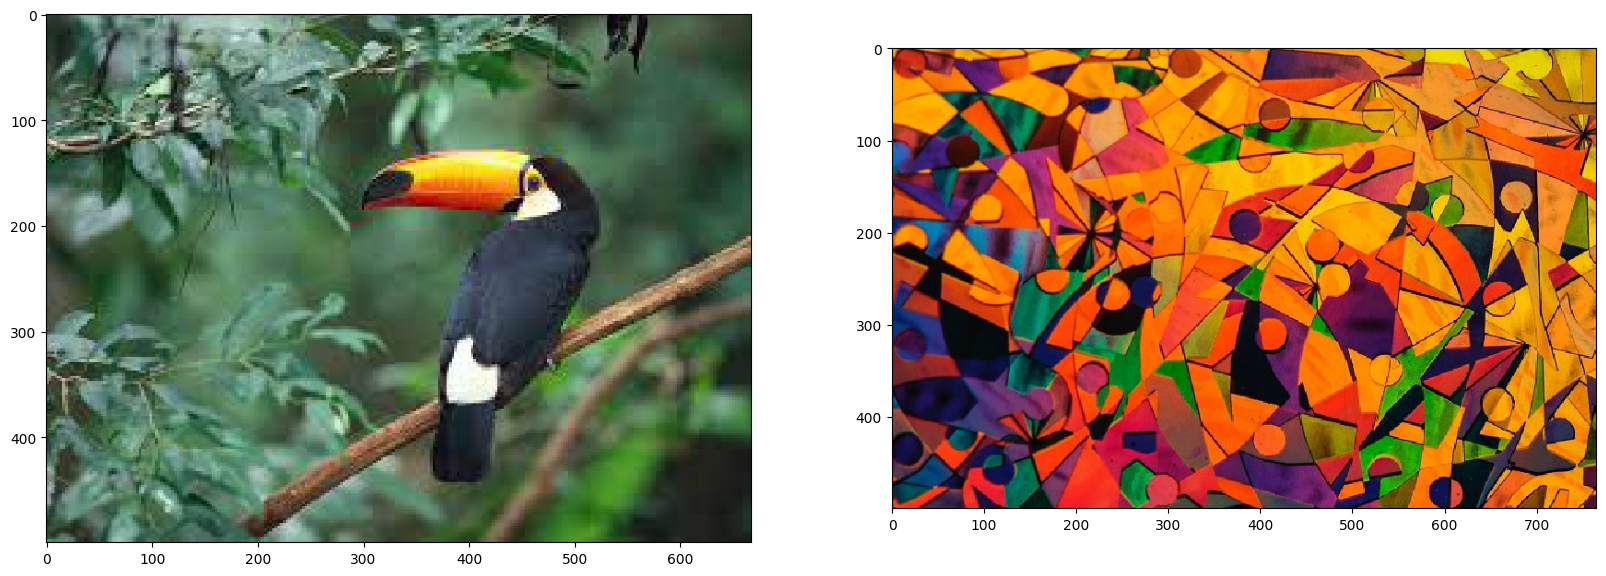

In [ ]:
# Show raw images
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
print("Raw Images -->")
ax1.imshow(content_image)
ax2.imshow(style_image)

In [ ]:
# Function to apply the specified convolutional kernel on the image
def apply_kernel(image, kernel):

    output = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)

    return output

In [ ]:
# This kernel is used to sharpen the image
content_kernel = np.array([ [0, -1, 0],
                            [-1,  5, -1],
                            [0, -1, 0]])

# This kernel is used to blur the image
style_kernel = np.array([ [0  , 0.2,    0],
                          [0.2, 0.2,  0.2],
                          [0  , 0.2,    0]])


In [ ]:
# Apply the kernels on the image
content_image = apply_kernel(content_image, content_kernel)
style_image = apply_kernel(style_image, style_kernel)

Images after applying convolutional kernels -->


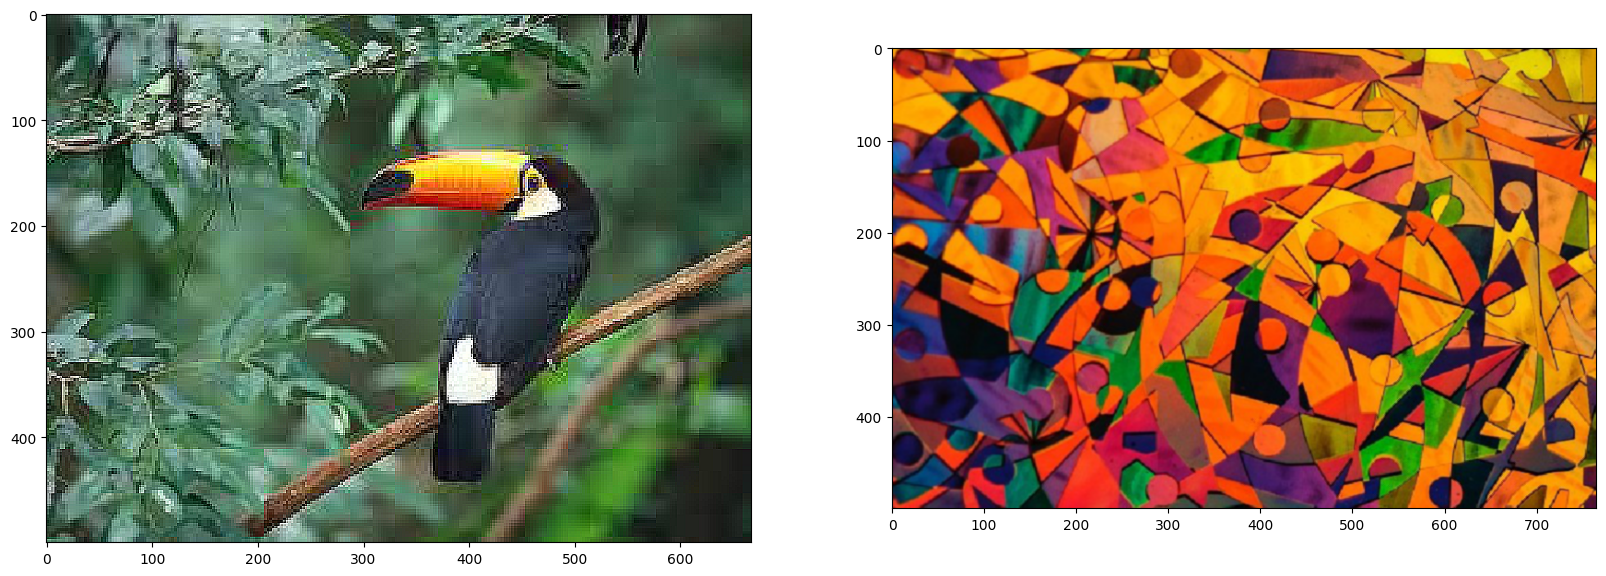

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
print("Images after applying convolutional kernels -->")
ax1.imshow(content_image)
ax2.imshow(style_image)

In [ ]:
def preprocess(image):
    '''
    Scales down the image values between 0 and 1
    Applies mean normalization on rgb channels
    Returns a tensor with a batch dimension added
    '''
    image = image / 255.0  # Normalize pixel values to [0, 1]

    # Apply mean normalization
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std

    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    image = tf.cast(image, tf.float32)
    image = tf.convert_to_tensor(image, dtype=tf.float32)

    return image

In [ ]:
# Preprocess the images
content_p = preprocess(content_image)
style_p = preprocess(style_image)

print("Content Shape = ", content_p.shape)
print("style shape = ", style_p.shape)

Content Shape =  (1, 500, 667, 3)
style shape =  (1, 500, 765, 3)


Preprocessed Images -->


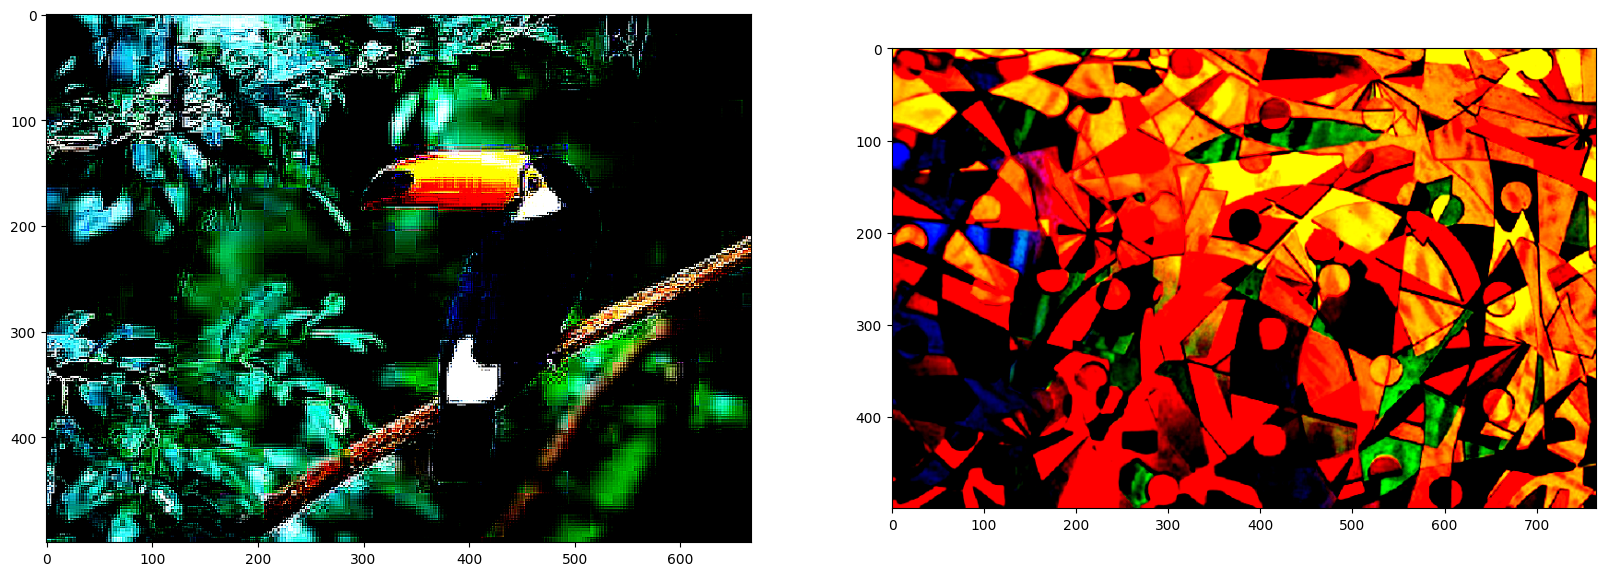

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
print("Preprocessed Images -->")
ax1.imshow(np.squeeze(content_p, axis=0))
ax2.imshow(np.squeeze(style_p, axis=0))

In [ ]:
def deprocess(tensor):
    '''
    Reverses the effect of mean normalization to return a normal image
    '''
    image = tensor.numpy()
    image = np.squeeze(image, axis=0)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    return image

In [ ]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)

print("deprocess content : ", content_d.shape)
print("deprocess style : ", style_d.shape)

deprocess content :  (500, 667, 3)
deprocess style :  (500, 765, 3)


In [ ]:
def get_features(image, model):
    '''
    This function passes the image through the convolutions of the
    model and keeps storing the outputs of specific layers mentioned
    in layers dictionary.
    '''
    layers = {
        'block1_conv1': 'conv1_1',
        'block2_conv1': 'conv2_1',
        'block3_conv1': 'conv3_1',
        'block4_conv1': 'conv4_1',
        'block4_conv2': 'conv4_2',
        'block5_conv1': 'conv5_1',
    }

    x = image
    features = {}

    for layer in model.layers:
        x = layer(x)

        if layer.name in layers:
            features[layers[layer.name]] = x

    return features

In [ ]:
# Dictionaries to store output of specified layers for both content and style image
content_f = get_features(content_p, vgg)
style_f = get_features(style_p, vgg)

In [ ]:
def gram_matrix(tensor):
    '''
    This function first converts a 2d image of 3 channels into 1d with 3 channels.
    then transposes the matrix and multiplies by itself forming the gram matrix.
    '''
    b, h, w, c = tensor.shape
    tensor = tf.reshape(tensor, (h * w, c))
    gram = tf.matmul(tensor, tensor, transpose_a=True)
    return gram

In [ ]:
# Dictionary to store gram matrices of each features of style image
style_grams = {layer: gram_matrix(style_f[layer]) for layer in style_f}

In [ ]:
# Computes corresponding differences, squares them and finds it's mean
def content_loss(target_conv4_2, content_conv4_2):
    loss = tf.reduce_mean(tf.square(target_conv4_2 - content_conv4_2))
    return loss

In [ ]:
# Weights assigned to these layers. These weights will be multiplied while calculating losses of each layer
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

In [ ]:
def style_loss(style_weights, target_features, style_grams):
    '''
    This function iterates over specified layers. First it takes the target feature
    of the current layer, then calculates it's gram matrix. Then it takes the corresponding
    gram matrix of style and calculates the mean squared loss between them. After that it
    multiplies the loss with layer weight and finds the average loss per pixel.
    '''
    loss = 0

    for layer in style_weights:
        target_f = target_features[layer]
        target_gram = gram_matrix(target_f)
        style_gram = style_grams[layer]
        b, h, w, c = target_f.shape
        layer_loss = style_weights[layer] * tf.reduce_mean(tf.square(target_gram - style_gram))
        loss += layer_loss / (c * w * h)

    return loss

In [ ]:
# Initially the target i.e the image we want to generate is started by taking it same as content image
target = tf.Variable(content_p, dtype=tf.float32)

# Generate features of the target image
target_f = get_features(target, vgg)

# Calculate losses
content_loss_value = content_loss(target_f['conv4_2'], content_f['conv4_2'])
style_loss_value = style_loss(style_weights, target_f, style_grams)

print("Content loss:", content_loss_value)
print("Style loss:", style_loss_value)


Content loss: tf.Tensor(0.0, shape=(), dtype=float32)
Style loss: tf.Tensor(895237.0, shape=(), dtype=float32)


In [ ]:
# Parameters for the model
learning_rate = 1e-3

alpha = 1 # Weight of content loss for finding total loss
beta = 1e5 # Weight of style loss for finding total loss

epochs = 3001
show_every = 500

optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
# Calculates total loss from content and style compared against target image
def total_loss(c_loss, s_loss, alpha, beta):
    loss = alpha * c_loss + beta * s_loss
    return loss

In [ ]:
# List to store target image at various steps to see transformation
results = []

'''
Starts with the content image as target. Computes both the losses.
Finds gradient of total loss with respect to the target image.
Then adam optimizer applies the gradients on the target image
to minimize loss for next iteration.
'''
for i in range(epochs):
    with tf.GradientTape() as tape:
        target_f = get_features(target, vgg)

        c_loss = content_loss(target_f['conv4_2'], content_f['conv4_2'])
        s_loss = style_loss(style_weights, target_f, style_grams)
        t_loss = total_loss(c_loss, s_loss, alpha, beta)

    gradients = tape.gradient(t_loss, target)
    optimizer.apply_gradients([(gradients, target)])

    if i % show_every == 0:
        print("Total Loss at Epoch {}: {}, Content Loss: {}, Style Loss: {}".format(i, t_loss, c_loss, s_loss))
        results.append(deprocess(target))


Total Loss at Epoch 0: 89523699712.0, Content Loss: 0.0, Style Loss: 895237.0
Total Loss at Epoch 500: 22362730496.0, Content Loss: 519.8777465820312, Style Loss: 223627.3125
Total Loss at Epoch 1000: 12939126784.0, Content Loss: 623.4247436523438, Style Loss: 129391.2578125
Total Loss at Epoch 1500: 9467648000.0, Content Loss: 659.4329833984375, Style Loss: 94676.46875
Total Loss at Epoch 2000: 7326671360.0, Content Loss: 678.4673461914062, Style Loss: 73266.7109375
Total Loss at Epoch 2500: 5730684416.0, Content Loss: 691.657470703125, Style Loss: 57306.83984375
Total Loss at Epoch 3000: 4445888000.0, Content Loss: 701.97265625, Style Loss: 44458.875


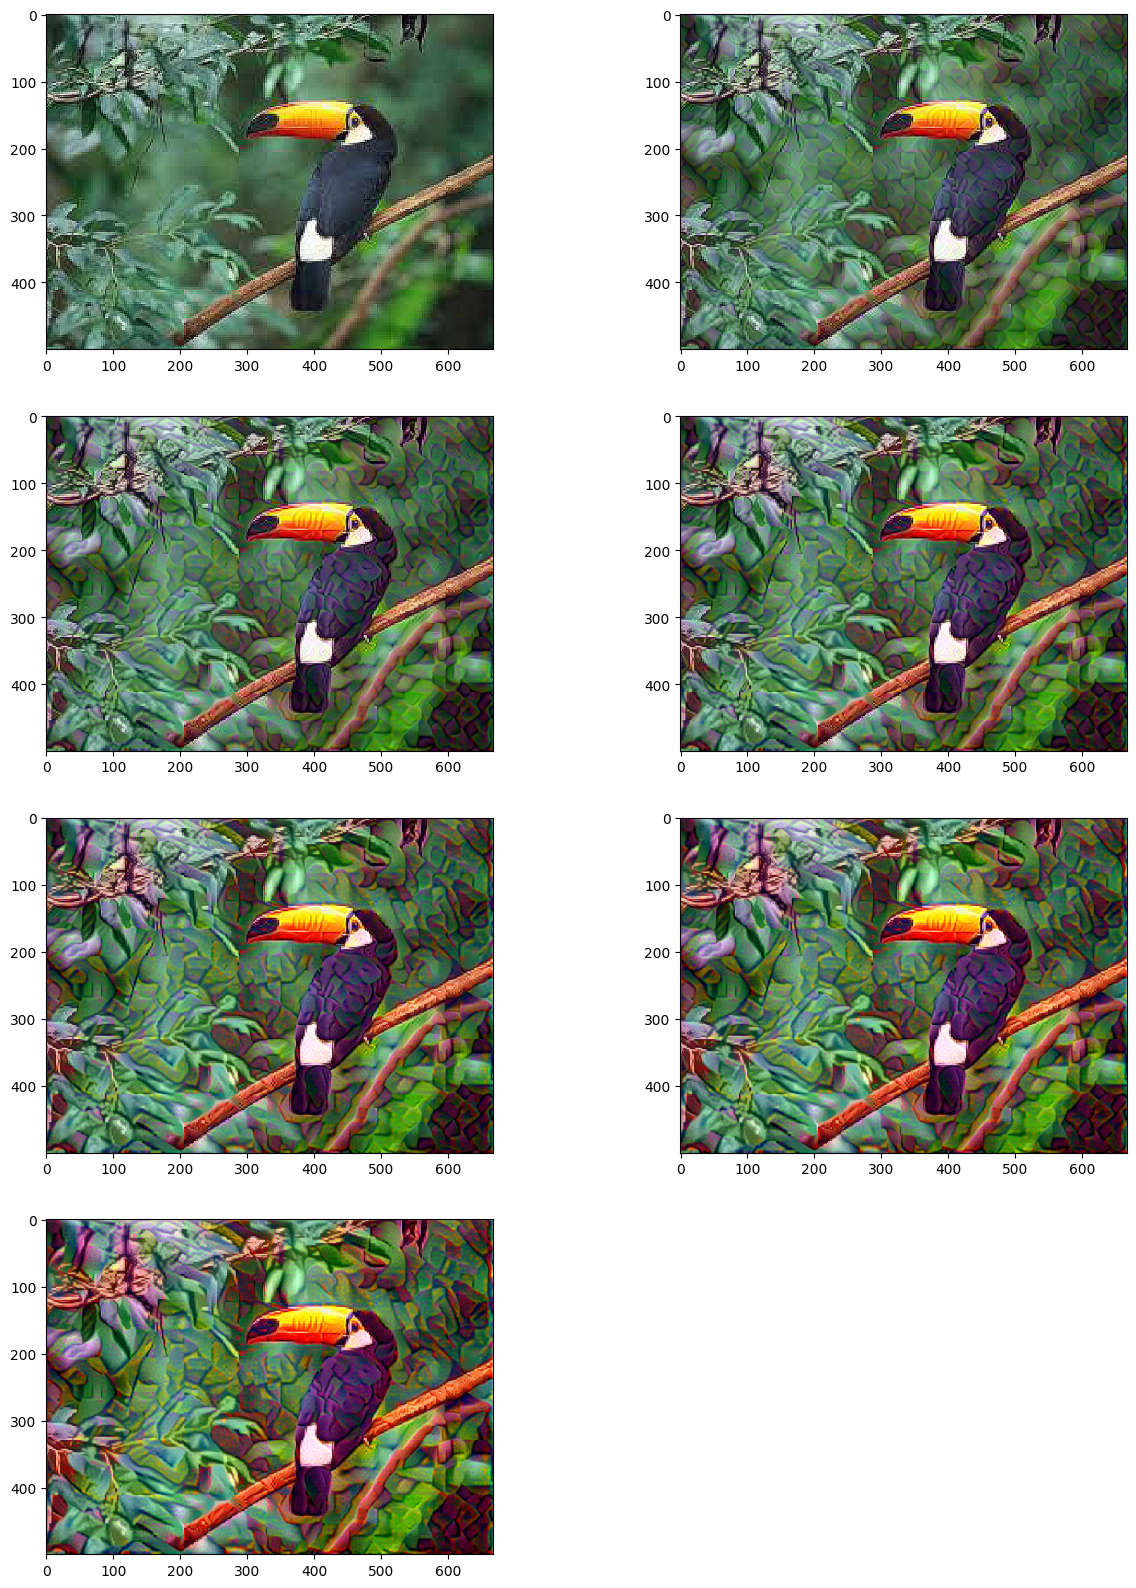

In [ ]:
# See the images at various time steps along the whole transformation
plt.figure(figsize = (15,20))

for i in range(len(results)):

  plt.subplot(4,2,i+1)
  plt.imshow(results[i])
plt.show()

Final Image -->


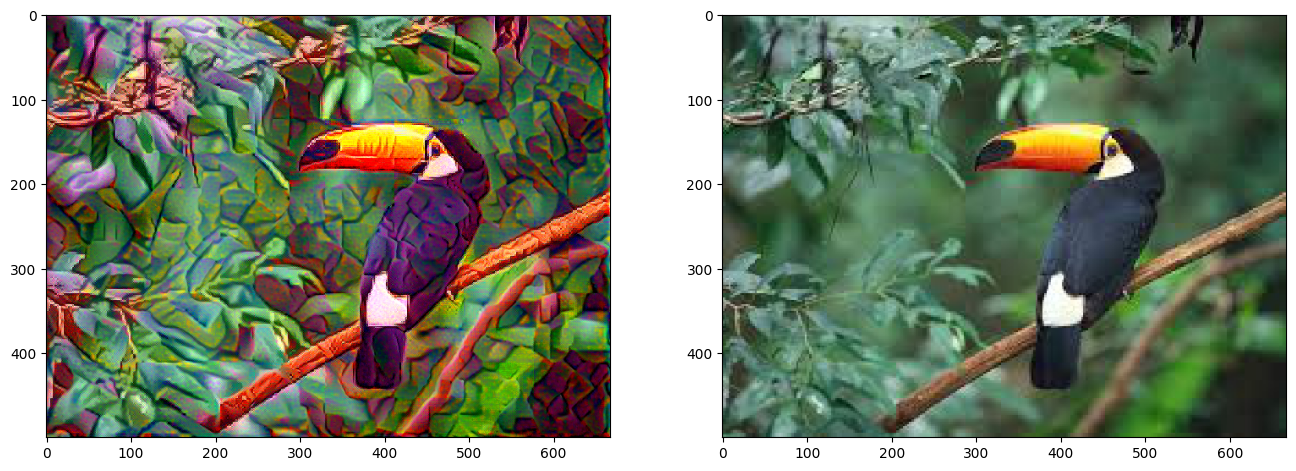

In [ ]:
target_copy = deprocess(target)
content_copy = deprocess(content_p)

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,10))
print("Final Image -->")
ax1.imshow(target_copy)
ax2.imshow(content_image_copy)

In [ ]:
# Save the final output image as jpg
tf.keras.preprocessing.image.save_img('output_image.jpg', target_copy)